$Arg \ min_y [scalarProd(f'(x), y-x) + \frac{1}{2} \cdot scalarProd(f''(x)(y-x), y-x) + \frac{M}{6} ||y-x||^3]$ для логистической регрессии – решаем спуском.

$y$ – текущие веса, размерность `[featureCount + 1, clsCount]` (`+ 1` из-за добавления `bias` признака). Заменяем на $W$.

$Arg \ min_W [scalarProd(f'(x), W-x) + \frac{1}{2} \cdot scalarProd(f''(x)(W-x), W-x) + \frac{M}{6} ||W-x||^3]$

$x$ – константа с весами, размерность `[featureCount + 1, clsCount]` (`+ 1` из-за добавления `bias` признака). Заменяем на $W_k$.

$Arg \ min_W [scalarProd(f'(W_k), W-W_k) + \frac{1}{2} \cdot scalarProd(f''(W_k)(W-W_k), W-W_k) + \frac{M}{6} ||W-W_k||^3]$

$f$ – заменяем на $cost$.

$Arg \ min_W [scalarProd(cost'_W(W_k), W-W_k) + \frac{1}{2} \cdot scalarProd(cost''_W(W_k)(W-W_k), W-W_k) + \frac{M}{6} ||W-W_k||^3]$

Меняем $cost''_W(W_k)(W-W_k)$ на $hVecProd$.

$Arg \ min_W [scalarProd(cost'_W(W_k), W-W_k) + \frac{1}{2} \cdot scalarProd(hVecProd(cost, W, W-W_k)(W_k), W-W_k) + \frac{M}{6} ||W-W_k||^3]$

Прописываем точный вызов градиента.

$Arg \ min_W [scalarProd(gradient(cost, W)(W_k), W-W_k) + \frac{1}{2} \cdot scalarProd(hVecProd(cost, W, W-W_k)(W_k), W-W_k) + \frac{M}{6} ||W-W_k||^3]$

$scalarProd$ трактуем как сумму поэлементных перемножений матриц, норма – корень из суммы квадратов элементов матрицы.

Повычисляем градиенты слагаемых аналитически.

Слагаемое 1:

$gradient(\frac{M}{6} || W - W_k||^3) = \dots$

$\frac{d \ \frac{M}{6} || W - W_k||^3}{d \ W[i]} =$

$= \frac{M}{6} \frac{d \ (\sum^n_{j=1}(W[j] - W_k[j])^2)^{\frac{3}{2}}}{d \ W[i]}=$

$= \frac{M}{6} \frac{3}{2} (\sum^n_{j=1}(W[j] - W_k[j])^2)^{\frac{1}{2}} \frac{d(W[i]-W_k[i])^2}{d \ W[i]}=$

$= \frac{M}{6} \frac{3}{2} ||W-W_k|| 2 (W[i]-W_k[i])=$

$= \frac{M}{2} ||W-W_k|| (W[i]-W_k[i])$

$\dots = \frac{M}{2} ||W-W_k|| (W-W_k)$

Слагаемое 2: TODO.

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.python.ops.gradients_impl import _hessian_vector_product
from tqdm import tqdm

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255
test_images = test_images / 255

In [3]:
feature_count = train_images.shape[1] * train_images.shape[2]
class_count = len(set(train_labels))

In [4]:
def result_vector(labels, object_ids):
    class_ids = labels[object_ids]
    answer = np.zeros((len(object_ids), class_count), dtype=np.float64)

    for i in range(len(object_ids)):
        answer[i][class_ids[i]] = 1
    return answer

def feature_vector(images, object_ids):
    flatten = images[object_ids].reshape((len(object_ids), feature_count))
    return np.append(flatten, np.ones((len(object_ids), 1)), axis=1)  # add bias feature

In [5]:
batch_size = 300

def get_random_samples_x_y():
    object_ids = random.sample(range(len(train_images)), batch_size)
    return feature_vector(train_images, object_ids), result_vector(train_labels, object_ids)

In [6]:
def get_test_data():
    object_ids = np.arange(len(test_images))
    return feature_vector(test_images, object_ids), result_vector(test_labels, object_ids)

test_features, test_answers = get_test_data()

In [7]:
# def scalar_prod(a, b):
#     products = tf.math.multiply(a, b)
#     return tf.reduce_sum(products)

step_factor = 0.001

x = tf.placeholder(tf.float64, [None, feature_count + 1], name="x")
y = tf.placeholder(tf.float64, [None, class_count], name="y")

M = tf.constant(6, tf.float64, name="M")

W_k = tf.Variable(tf.zeros([feature_count + 1, class_count], tf.float64), name="W_k")
W = tf.Variable(tf.zeros([feature_count + 1, class_count], tf.float64), name="W")

predictions = tf.nn.softmax(tf.matmul(x, W_k))
cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=predictions, labels=y)

g = tf.gradients(cost, W_k)[0]
h_vec_prod = _hessian_vector_product(cost, [W_k], [W - W_k])[0]

g_value = tf.Variable(tf.zeros([feature_count + 1, class_count], tf.float64), name="g_value")
update_g_value = g_value.assign(g)

target_0_g = g_value
target_1_g = 0.5 * (tf.gradients(h_vec_prod, W_k)[0] * (W - W_k) + h_vec_prod)
target_2_g = M / 2 * tf.norm(W - W_k) * (W - W_k)
target_g = target_0_g + target_1_g + target_2_g

update_W = W.assign_sub(step_factor * target_g)

update_W_k = W_k.assign(W)

init = tf.global_variables_initializer()

def calc_accuracy(sess):
    predictions_count = len(test_images)
    predicted = sess.run(predictions, feed_dict={x: test_features})
    correct = sum(np.argmax(predicted, axis=1) == np.argmax(test_answers, axis=1))

    return correct / predictions_count

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
maximum_steps = 10
maximum_major_steps = 70

history = pd.DataFrame(columns=[
    "test_accuracy",
])

with tf.Session() as sess:
    sess.run(init)

    with tqdm(total=maximum_major_steps * maximum_steps) as pbar:
        for major_steps in range(maximum_major_steps):
            features, answers = get_random_samples_x_y()
            sess.run(update_g_value, feed_dict={x: features, y: answers})

            for steps in range(maximum_steps):
                accuracy = calc_accuracy(sess)
                history.loc[len(history)] = [accuracy]

                sess.run(update_W, feed_dict={x: features, y: answers})
                pbar.update(1)

            sess.run(update_W_k)

    W_trained = sess.run(W)
    print(W_trained)

100%|██████████| 700/700 [00:38<00:00, 18.00it/s]


[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.0744677   0.25962625 -0.06572684 ...  0.15678982 -0.41401763
  -0.07764122]]


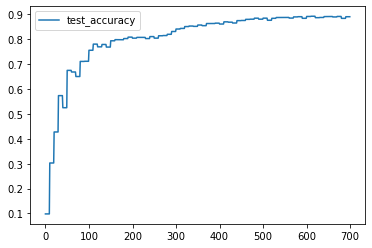

In [9]:
history.plot()
plt.show()

In [10]:
with tf.Session() as sess:
    sess.run(W_k.assign(W_trained))

    final_accuracy = calc_accuracy(sess)

print("correct ratio:", final_accuracy)

correct ratio: 0.8912
